In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from notebooks.create_spectrogram import (
    create_spectrograms_from_audio_dataset,
    extract_patches_from_audio_dataset 
)
from notebooks.helper_functions import (
    convert_prefetchdataset_to_numpy_arrays,
    )

Time-series

In [5]:
train_dataset = tf.keras.utils.audio_dataset_from_directory("../../dataset/training", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=False, seed=3407)
val_dataset = tf.keras.utils.audio_dataset_from_directory("../../dataset/validation", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=False, seed=3407)

time_ser_x_train_np, time_ser_y_train_np = convert_prefetchdataset_to_numpy_arrays(train_dataset, data_type="time-series")
time_ser_x_val_np, time_ser_y_val_np = convert_prefetchdataset_to_numpy_arrays(val_dataset, data_type="time-series")

Found 11292 files belonging to 2 classes.


2024-09-22 14:48:20.131217: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-22 14:48:20.132337: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-09-22 14:48:20.263544: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
2024-09-22 14:48:20.280506: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available


Found 1380 files belonging to 2 classes.


Spectrograms

In [6]:
train_spectrogram_ds = create_spectrograms_from_audio_dataset(train_dataset, sample_rate = 16000) #.cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = create_spectrograms_from_audio_dataset(val_dataset, sample_rate = 16000) #.cache().prefetch(tf.data.AUTOTUNE)

spec_x_train_np, spec_y_train_np = convert_prefetchdataset_to_numpy_arrays(train_spectrogram_ds)
spec_x_val_np, spec_y_val_np = convert_prefetchdataset_to_numpy_arrays(val_spectrogram_ds)

Patches

In [7]:
train_patches_ds = extract_patches_from_audio_dataset(train_dataset, sample_rate = 16000, patch_size=8) #.cache().prefetch(tf.data.AUTOTUNE)
val_patches_ds = extract_patches_from_audio_dataset(val_dataset, sample_rate = 16000, patch_size=8) #.cache().prefetch(tf.data.AUTOTUNE)

patch_x_train_np, patch_y_train_np = convert_prefetchdataset_to_numpy_arrays(train_patches_ds, data_type="not spectrogram")
patch_x_val_np, patch_y_val_np = convert_prefetchdataset_to_numpy_arrays(val_patches_ds, data_type="not spectrogram")

In [13]:
models_data = [
    ("../../models/spectrogram_models_from_notebooks/cnn/quantized/cnn_mel_spec_full_int_q.tflite", "CNN-Mel"), 
    ("../../models/spectrogram_models_from_notebooks/squeezenet/squeezenet_spec_16kHz_full_int_q.tflite", "SqueezeNet-Mel"), 
    ("../../models/spectrogram_models_from_notebooks/bnn/hpo/bnn_mel_spec_full_int_q.tflite", "BNN-Mel"),
    ('../../models/spectrogram_models_from_notebooks/vit/quantized/vit_mel_spec_full_int_q.tflite', "Transformer-Mel"),
    ("../../models/time_series_models_from_notebooks/cnn/quantized/cnn_time_series_full_int_q.tflite", "CNN-Time"), 
    ("../../models/time_series_models_from_notebooks/squeezenet/squeezenet30%_time_series_16kHz_full_int_q.tflite", "SqueezeNet-Time"), 
    ("../../models/time_series_models_from_notebooks/bnn/hpo/bnn_time_ser_full_int_q.tflite", "BNN-Time"),
    ("../../models/time_series_models_from_notebooks/tiny_transformer/quantized/tiny_transformer_time_series_full_int_q.tflite", "Transformer-Time"),
          ]

In [14]:
# Functions to predict using full integer models

def run_full_int_q_tflite_model(tflite_file, indices, x_data):
  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions_prob = np.zeros((len(indices),), dtype=int)
  predictions_class = np.zeros((len(indices),), dtype=int)
  for i, test_image_index in enumerate(indices):
    test_data_point = x_data[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_data_point = test_data_point / input_scale + input_zero_point

    test_data_point = np.expand_dims(test_data_point, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_data_point)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    # print(output)
    predictions_class[i] = output.argmax()
    predictions_prob[i] = output[1]
    # print(output[0]+ output[1])
    # print(predictions[i])

  return predictions_prob, predictions_class

def full_int_model_predict(tflite_file, x_data):
  indices = range(len(x_data))
  predictions = run_full_int_q_tflite_model(tflite_file, indices, x_data)
  return predictions

In [15]:
models_y_predictions = {}
models_optimal_thresholds = {}

In [16]:
def models_predict():
    for model_data in models_data:
        if model_data[1].endswith("Mel"):
            if model_data[1].startswith("Transformer"):
                y_prob = full_int_model_predict(model_data[0], patch_x_val_np)
            else:
                y_prob = full_int_model_predict(model_data[0], spec_x_val_np)
        elif model_data[1].endswith("Time"):
            y_prob = full_int_model_predict(model_data[0], time_ser_x_val_np)
        models_y_predictions[model_data[1]] = y_prob

def models_auc_roc_curve():
    for model, y_predictions in models_y_predictions.items():
        fpr, tpr, thresholds = roc_curve(spec_y_val_np, y_predictions[0])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linestyle='-.', label=f'{model}, AUC: %0.2f' % roc_auc)


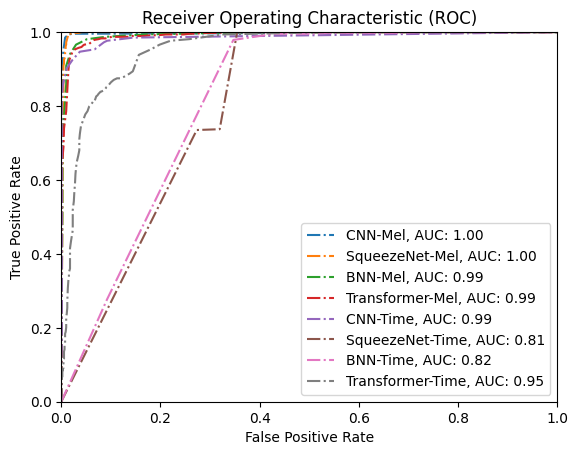

In [23]:
fig = plt.figure()
models_predict()
models_auc_roc_curve()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [24]:
fig.savefig("../../figures/ROCs_of_tinyML_models_val_dataset.pdf", bbox_inches='tight')

CNN-Mel
SqueezeNet-Mel
BNN-Mel
Transformer-Mel
CNN-Time
SqueezeNet-Time
BNN-Time
Transformer-Time




[<matplotlib.lines.Line2D object at 0x7fd8e5678b80>, <matplotlib.lines.Line2D object at 0x7fd8e5678e20>, <matplotlib.lines.Line2D object at 0x7fd8e5606100>, <matplotlib.lines.Line2D object at 0x7fd8e56063a0>, <matplotlib.lines.Line2D object at 0x7fd8e5606640>, <matplotlib.lines.Line2D object at 0x7fd8e56068e0>, <matplotlib.lines.Line2D object at 0x7fd8e5606b50>, <matplotlib.lines.Line2D object at 0x7fd8e5606df0>] ['CNN-Mel', 'SqueezeNet-Mel', 'BNN-Mel', 'Transformer-Mel', 'CNN-Time', 'SqueezeNet-Time', 'BNN-Time', 'Transformer-Time']


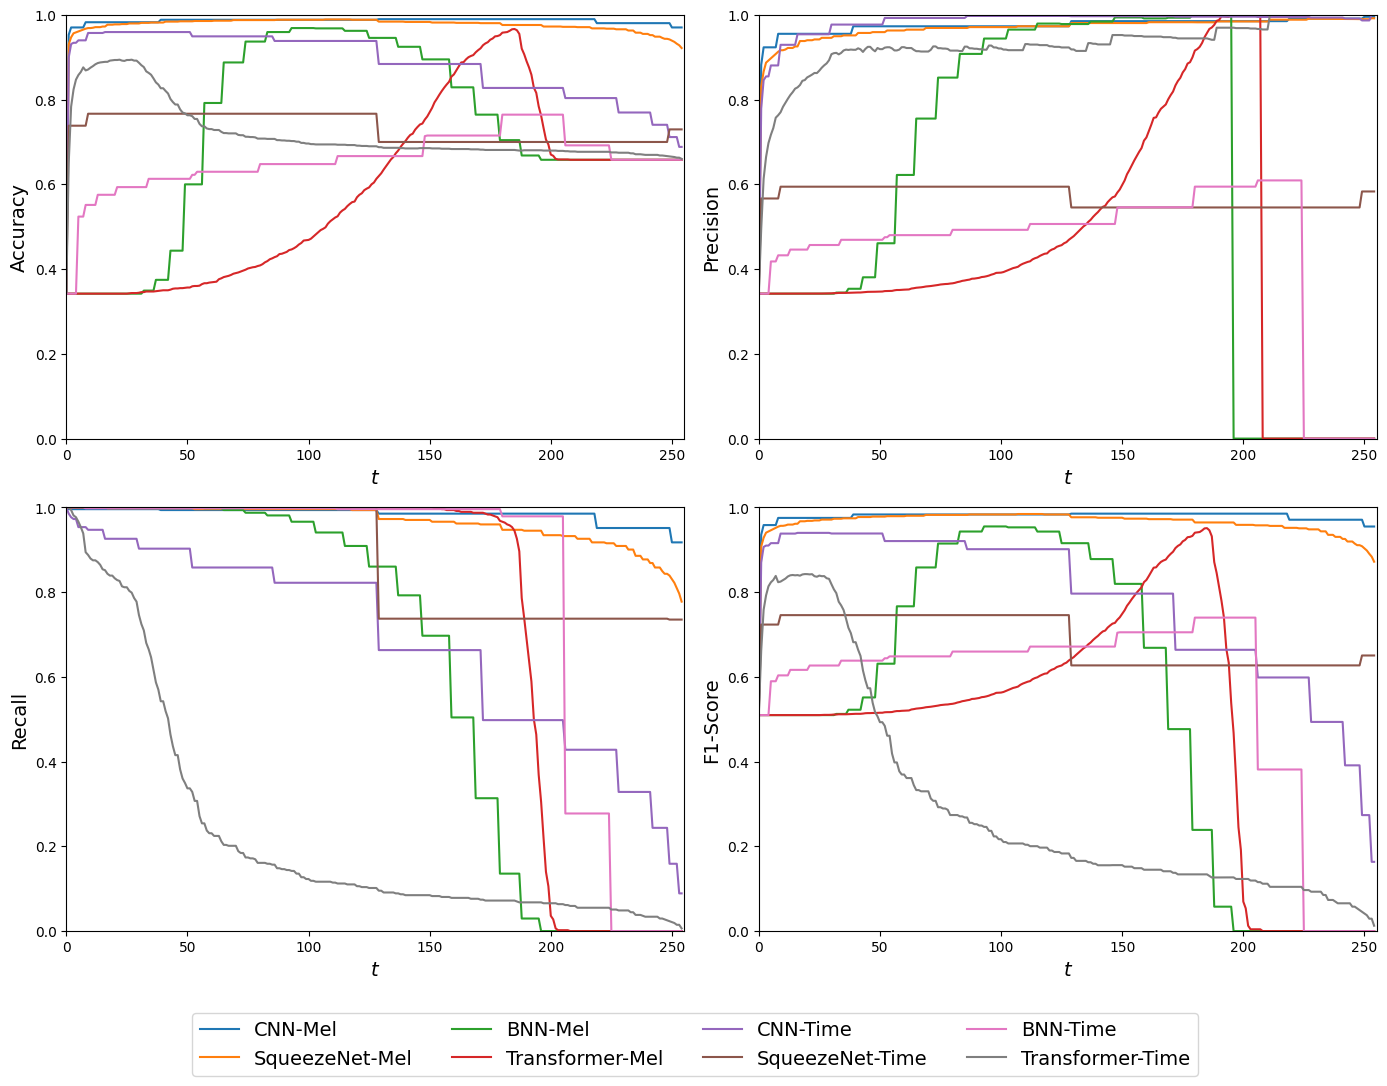

In [21]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

#  Define thresholds
thresholds = np.arange(0, 255, 1)

# Prepare a dictionary to hold the metrics for each model
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}


# Calculate metrics for each model at each threshold
for model_name, predictions in models_y_predictions.items():
    print(model_name)
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
       
    for threshold in thresholds:
        y_pred = (predictions[0] >= threshold).astype(int)
        
        acc = accuracy_score(time_ser_y_val_np, y_pred)
        prec = precision_score(time_ser_y_val_np, y_pred)
        rec = recall_score(time_ser_y_val_np, y_pred)
        f1 = f1_score(time_ser_y_val_np, y_pred)
        
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)
    
    metrics['accuracy'].append(accuracies)
    metrics['precision'].append(precisions)
    metrics['recall'].append(recalls)
    metrics['f1_score'].append(f1_scores)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Titles for subplots
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

thresholds_normalized = thresholds #/ 255.0
# Subplots (2x2)
for i, metric_name in enumerate(metric_names):
    print()
    ax = axs[i // 2, i % 2]
    for j, model_name in enumerate(models_y_predictions.keys()):
        ax.plot(thresholds_normalized, metrics[metric_name.lower().replace("-", "_")][j], label=model_name)
    # ax.set_title(metric_name, fontsize=14,)
    ax.set_xlabel('$\it{t}$', fontsize=14,)
    ax.set_ylabel(metric_name, fontsize=14,)
    # ax.legend()
    ax.grid(False)
    ax.set_xlim(0, 255)  # Set x-axis limits
    ax.set_ylim(0, 1)  # Set y-axis limits

# Create a single legend for all plots
# Handles and labels for the legend
handles, labels = [], []
line, label = axs[0, 0].get_legend_handles_labels()
print(line, label)
handles.extend(line)
labels.extend(label)

fig.legend(handles, labels, fontsize=14, loc='center', ncol=4, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()

In [22]:
fig.savefig("../../figures/decision_thresholds_val_dataset.pdf", bbox_inches='tight')